## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import time
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
import tensorflow as tf

In [3]:
from library.datasets.cifar10 import CIFAR10
from library.plot_tools import plot
from library.utils import file_utils
from library.tf.models.cnn_classifier import CNNClassifier

## Select Tensorflow device

In [4]:
# from tensorflow.python.client import device_lib
# local_device_protos = device_lib.list_local_devices()
# cpu_devices = [x.name for x in local_device_protos if x.device_type == 'CPU']
# gpu_devices = [x.name for x in local_device_protos if x.device_type == 'GPU']
# print('Available CPU Devices: ', end='')
# print(cpu_devices)
# print('Available GPU Devices: ', end='')
# print(gpu_devices)
# if len(gpu_devices) == 0:
#     if len(cpu_devices) > 0:
#         device_name = '/cpu:0'
#         print('Using CPU: %s' %device_name)
#     else:
#         print('No CPU present in the system!!!')
# else:
#     device_name = '/gpu:0'
#     print('Using GPU: %s' %device_name)

In [5]:
total_time = 0

## Experiment

In [6]:
exp_no = 2
data_source = 'Website'
num_images_required = 1.0
file_no = 105

### Parameters for experiment

In [7]:
device_name = '/gpu:0'
learn_rate = 0.001
train_epochs = 50
display_step = 1
reg_const = 0.01
train_val_split_data = None
train_val_split = 0.8
transform = True
transform_method = 'StandardScaler'
learn_rate_type = 'constant'
dataset = 'cifar10'
descent_method = 'adam'
batch_size = 96
model_restore = False

### Log directories

In [8]:
log_dir = '../logs/' + dataset + '/' + str(file_no).zfill(3) + '_tf_cnn_raw/exp_no_' + str(exp_no).zfill(3) + '/'
log_file = log_dir + 'cnn_classifier.ckpt'
model_file = log_dir + 'cnn_classifier.pb'
print('Writing tensorboard logs to %s' % log_file)
print('View logs by running tensorboard: ', end='')
print('\"tensorboard --logdir=\'./%s/105_tf_cnn_raw/\' --port 61111\"' % dataset)

Writing tensorboard logs to ../logs/cifar10/105_tf_cnn_raw/exp_no_002/cnn_classifier.ckpt
View logs by running tensorboard: "tensorboard --logdir='./cifar10/105_tf_cnn_raw/' --port 61111"


## Step 1: Load CIFAR 10 Dataset

In [9]:
start = time.time()
one_hot = True
make_image = True
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, preprocess='StandardScaler',
                  train_validate_split=train_val_split_data, make_image=make_image, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 1] Loaded CIFAR 10 Dataset in %.4f ms' %((end-start)*1000))
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 50000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5


/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 5.5624 seconds
[ Step 1] Loaded CIFAR 10 Dataset in 5563.0589 ms


In [10]:
# print('Train data shape:', cifar10.train.data.shape)
# if one_hot is True:
#     print('Train labels shape:', cifar10.train.one_hot_labels.shape)
# print('Train class labels shape:', cifar10.train.class_labels.shape)
# if train_val_split_data is not None:
#     print('Validate data shape:', cifar10.validate.data.shape)
#     if one_hot is True:
#         print('Validate labels shape:', cifar10.validate.one_hot_labels.shape)
#     print('Validate class labels shape:', cifar10.validate.class_labels.shape)
# print('Test data shape:', cifar10.test.data.shape)
# if one_hot is True:
#     print('Test labels shape:', cifar10.test.one_hot_labels.shape)
# print('Test class labels shape:', cifar10.test.class_labels.shape)

In [11]:
# print('Training images')
# print(cifar10.train.data[:5])
# if one_hot is True:
#     print('Training labels')
#     print(cifar10.train.one_hot_labels[:5])
# print('Training classes')
# print(cifar10.train.class_labels[:5])
# print('Testing images')
# print(cifar10.test.data[:5])
# if one_hot is True:
#     print('Testing labels')
#     print(cifar10.test.one_hot_labels[:5])
# print('Testing classes')
# print(cifar10.test.class_labels[:5])

## Step 1.1 Load sample images

Plotting CIFAR 10 Train Dataset


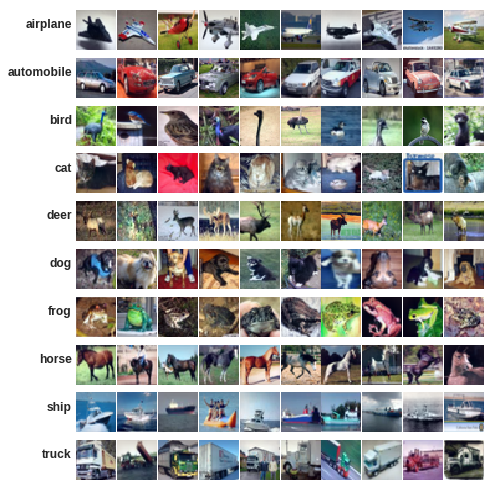

Plotting CIFAR 10 Test Dataset


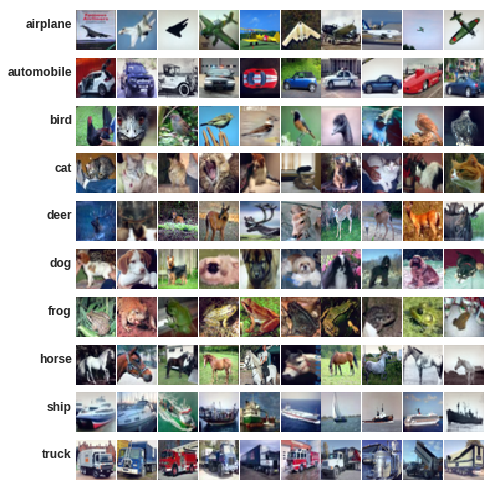

In [12]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

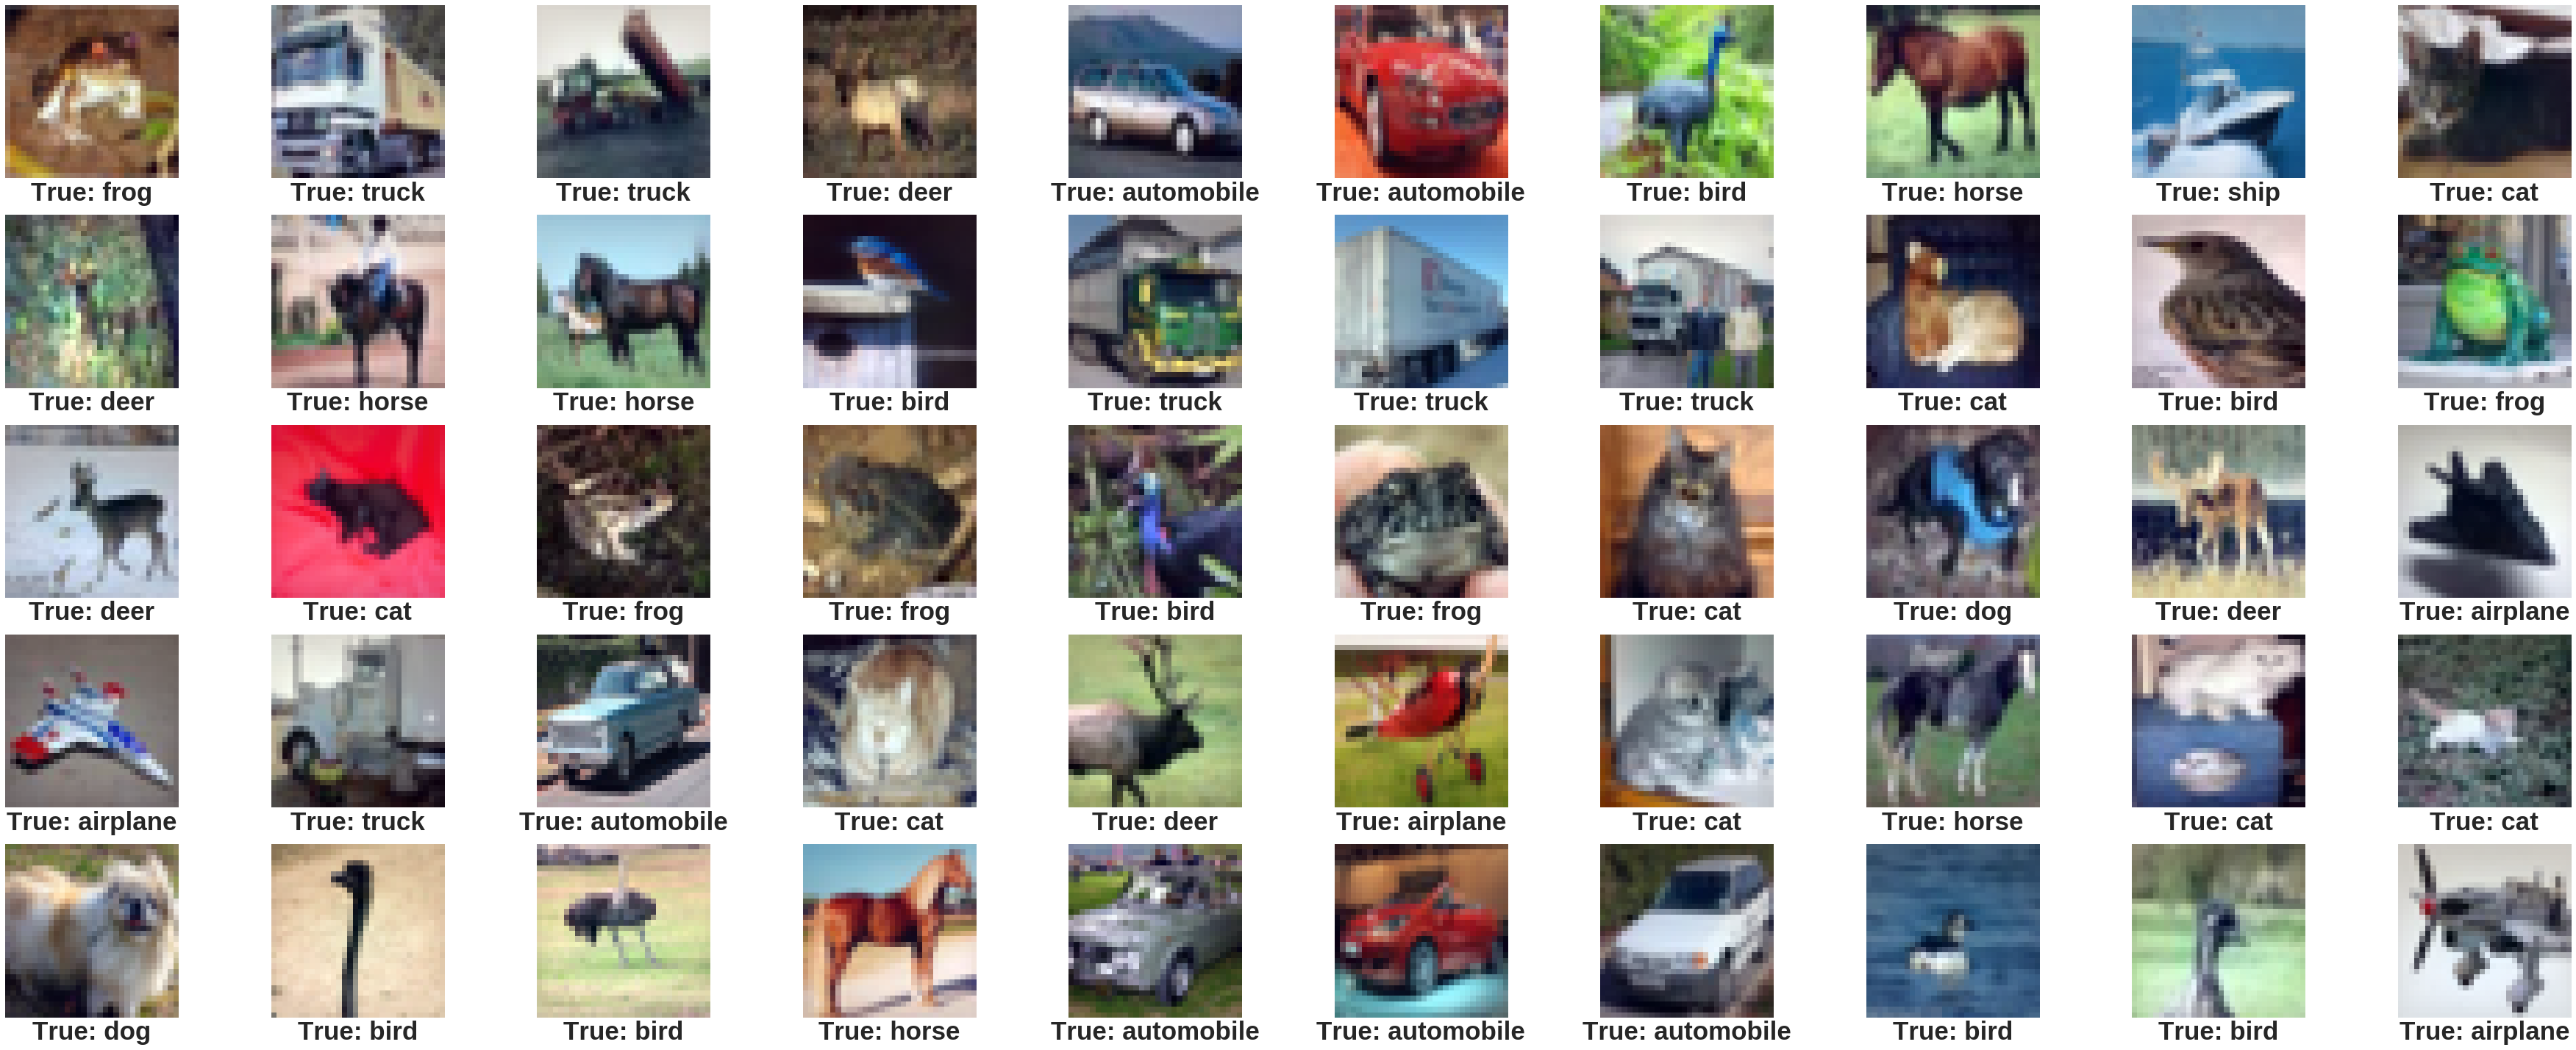

True

In [13]:
cifar10.plot_images(cifar10.train.data[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

## Step 2: Convolution Neural Network

In [14]:
image_shape = cifar10.train.images[1,:].shape
num_classes = 10

In [15]:
network_config = {'conv_layer_1': {'weight': {'name': 'Weight_conv_layer_1', 'type': 'random_normal'},
                                          'bias': {'name': 'Bias_conv_layer_1', 'type': 'zeros'},
                                          'activation_fn': 'relu',
                                          'stride': 1, 'padding': 'SAME',
                                          'filter_size': 3, 'num_outputs': 32,
                                          'layer_name': 'Convolution_Layer_1'
                                  },
                 'max_pool_layer_1': {'stride': 2, 'overlap': 2, 'padding': 'SAME',
                                      'layer_name': 'MaxPool_Layer_1'
                                     },
                  'conv_layer_2': {'weight': {'name': 'Weight_conv_layer_2', 'type': 'random_normal'},
                                          'bias': {'name': 'Bias_conv_layer_2', 'type': 'zeros'},
                                          'activation_fn': 'relu',
                                          'stride': 1, 'padding': 'SAME',
                                          'filter_size': 3, 'num_outputs': 128,
                                          'layer_name': 'Convolution_Layer_2'
                                  },
                  'max_pool_layer_2': {'stride': 2, 'overlap': 2, 'padding': 'SAME',
                                      'layer_name': 'MaxPool_Layer_2'
                                     },
                  'conv_layer_3': {'weight': {'name': 'Weight_conv_layer_3', 'type': 'random_normal'},
                                          'bias': {'name': 'Bias_conv_layer_3', 'type': 'zeros'},
                                          'activation_fn': 'relu',
                                          'stride': 1, 'padding': 'SAME',
                                          'filter_size': 3, 'num_outputs': 512,
                                          'layer_name': 'Convolution_Layer_3'
                                  },
                 'max_pool_layer_3': {'stride': 2, 'overlap': 2, 'padding': 'SAME',
                                      'layer_name': 'MaxPool_Layer_3'
                                     },
                 'full_connected_layer_1': {'weight': {'name': 'Full_Weight_full_connect', 'type': 'truncated_normal'},
                                            'bias': {'name': 'Full_Bias_full_connect', 'type': 'zeros'},
                                            'activation_fn': 'relu', 'num_outputs': 1024, 'dropout': 0.5,
                                            'layer_name': 'Full_Connected_Layer'
                                           },
                  'output_layer': {'weight': {'name': 'Output_Weight_output', 'type': 'truncated_normal'},
                                   'bias': {'name': 'Output_Bias_output', 'type': 'zeros'},
                                   'activation_fn': 'relu',
                                   'layer_name': 'Output_Layer'
                                  }
                 }

In [16]:
augmentation = {'flip_left_right': {'seed': 1},
                'rotate': {'max_angle': 20}}
augmentation_01 = {'flip_left_right': {'seed': 1}}
augmentation_02 = {'rotate': {'max_angle': 20}}
# augmentation = None

In [17]:
cnn = CNNClassifier(verbose=False, device=device_name, session_type='interactive', num_iter=train_epochs, 
                    err_tolerance=1e-7, train_validate_split=train_val_split, display_step=display_step,
                    learn_step=10, learn_rate_type=learn_rate_type, learn_rate=learn_rate, batch_size=batch_size, 
                    logs=True, log_dir=log_dir, test_log=True, save_model=False, checkpoint_filename=log_file, 
                    save_checkpoint=True, restore=model_restore, model_name=model_file, 
                    descent_method=descent_method, config=network_config, augmentation=augmentation)

Performing augmentation


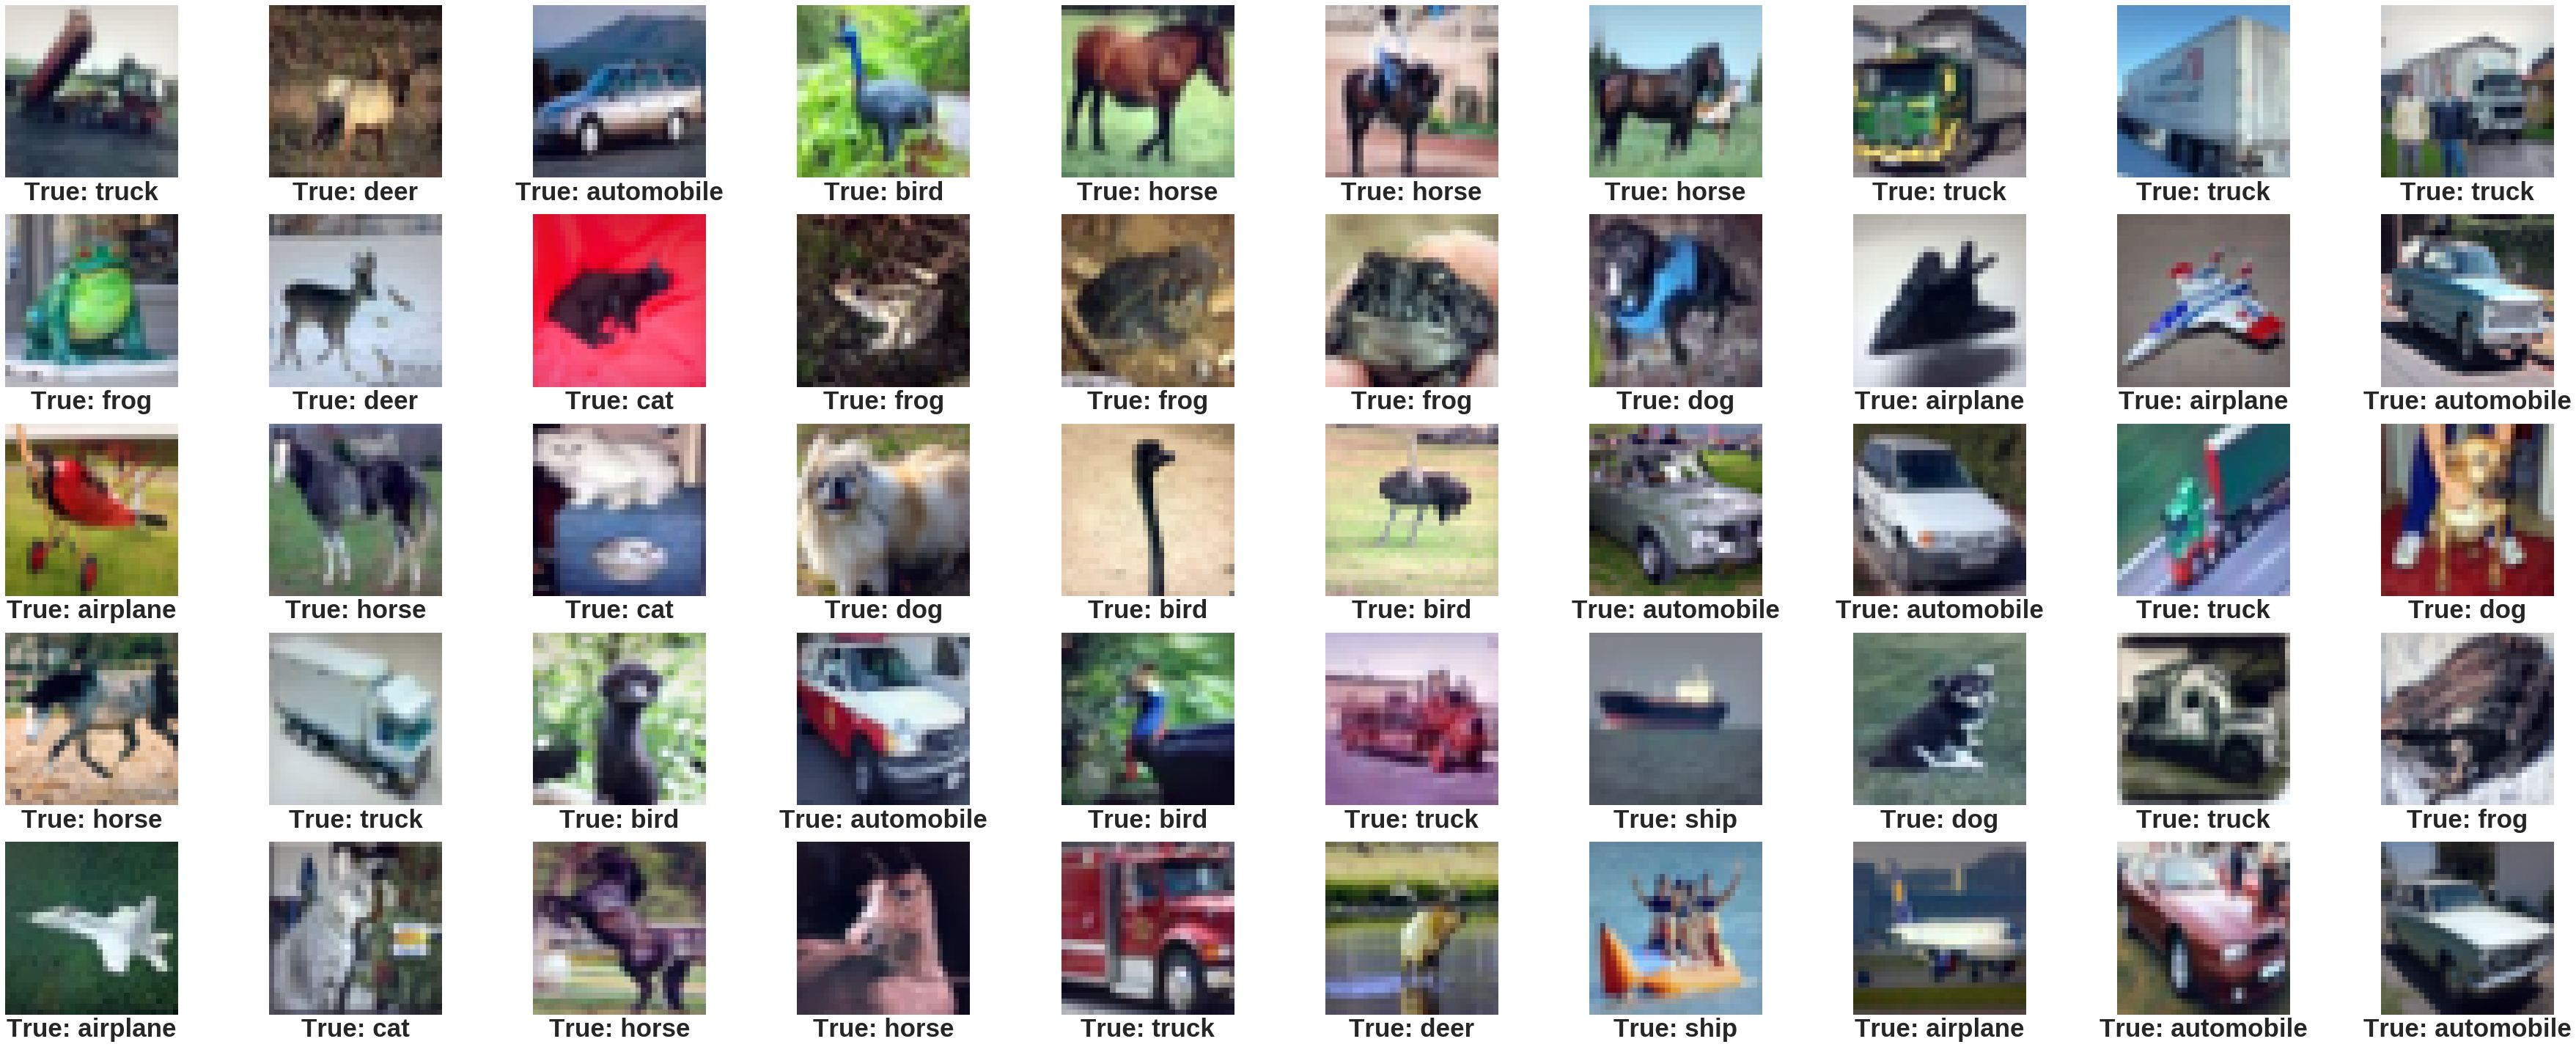

True

In [18]:
cnn.augmentation = augmentation_01
data, labels, classes = cnn.make_data(cifar10.train.images, cifar10.train.one_hot_labels, cifar10.train.class_labels)
prediction_classes = []
classes = np.array(classes)
for i in range(classes.shape[0]):
    prediction_classes.append(cifar10.classes[int(classes[i])])
prediction_classes = np.array(prediction_classes)
cifar10.plot_images(data[:50, :], prediction_classes[:50], nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=False)

Performing augmentation


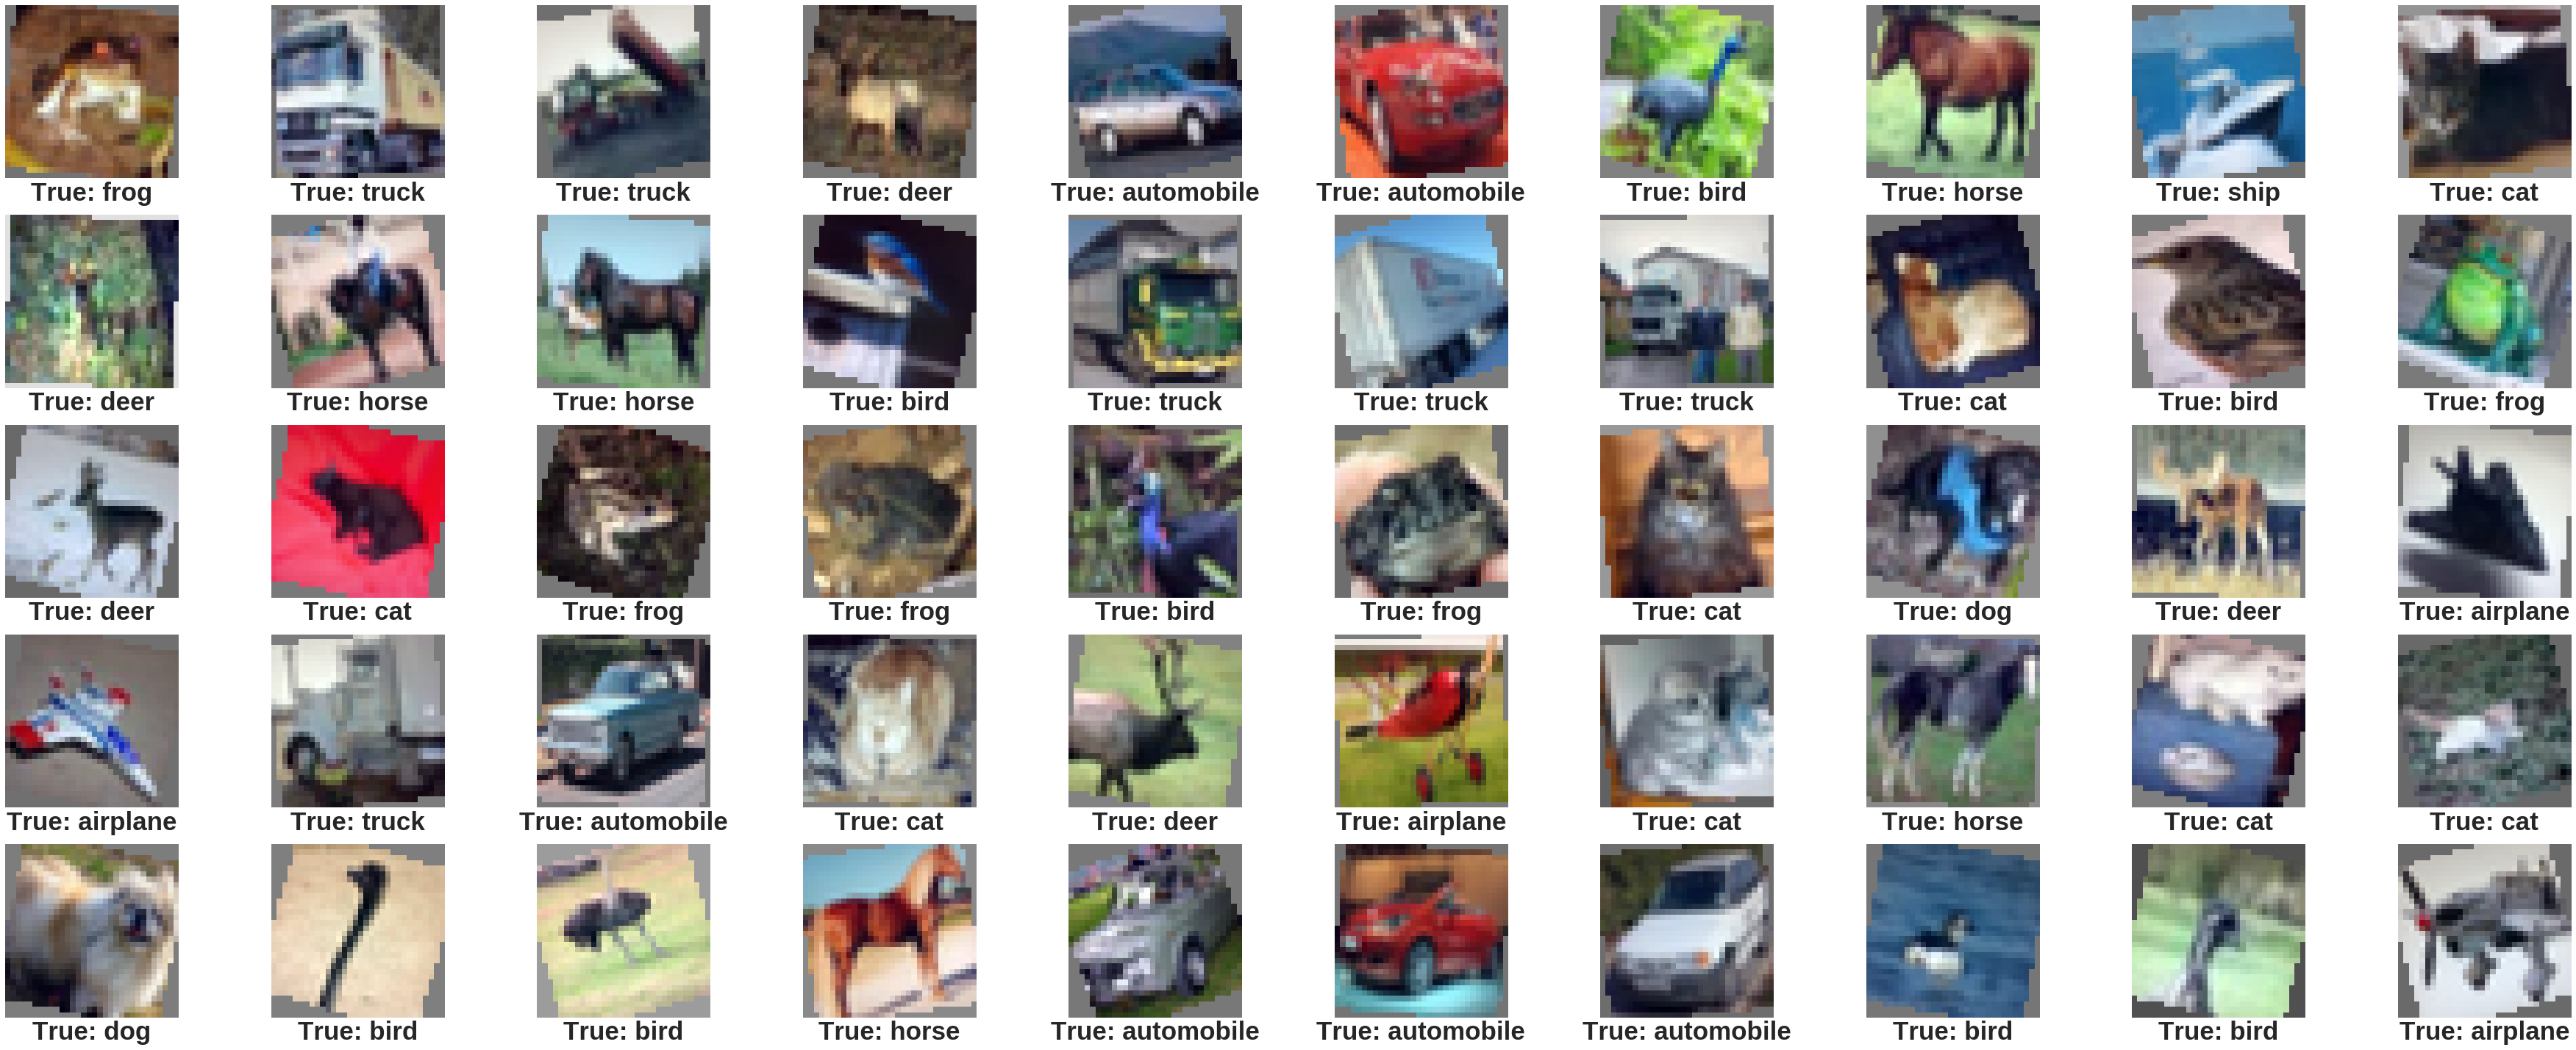

True

In [19]:
cnn.augmentation = augmentation_02
data, labels, classes = cnn.make_data(cifar10.train.images, cifar10.train.one_hot_labels, cifar10.train.class_labels)
prediction_classes = []
classes = np.array(classes)
for i in range(classes.shape[0]):
    prediction_classes.append(cifar10.classes[int(classes[i])])
prediction_classes = np.array(prediction_classes)
cifar10.plot_images(data[:50, :], prediction_classes[:50], nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=False)

### Step 2.2: Create the tensorflow graph

In [20]:
start = time.time()
cnn.augmentation = augmentation
cnn.create_graph(image_shape, num_classes=num_classes)
end = time.time()
print('Generated the tensorflow graph in %.4f ms' %((end-start)*1000))
total_time = (end-start)

None -> conv_layer_1
Making convolution layer: conv_layer_1
3 3 3 32
Input shape: [None, 32, 32, 3]
Weight_conv_layer_1
Output shape: [None, 32, 32, 32]
conv_layer_1 -> max_pool_layer_1
Making max pool layer: max_pool_layer_1
Input shape: [None, 32, 32, 32]
Output shape: [None, 16, 16, 32]
max_pool_layer_1 -> conv_layer_2
Making convolution layer: conv_layer_2
3 3 32 128
Input shape: [None, 16, 16, 32]
Weight_conv_layer_2
Output shape: [None, 16, 16, 128]
conv_layer_2 -> max_pool_layer_2
Making max pool layer: max_pool_layer_2
Input shape: [None, 16, 16, 128]
Output shape: [None, 8, 8, 128]
max_pool_layer_2 -> conv_layer_3
Making convolution layer: conv_layer_3
3 3 128 512
Input shape: [None, 8, 8, 128]
Weight_conv_layer_3
Output shape: [None, 8, 8, 512]
conv_layer_3 -> max_pool_layer_3
Making max pool layer: max_pool_layer_3
Input shape: [None, 8, 8, 512]
Output shape: [None, 4, 4, 512]
max_pool_layer_3 -> full_connected_layer_1
Making full connected layer: full_connected_layer_1
Inpu

In [21]:
cnn.print_parameters()

Parameters for CNN classifier
>> Input Parameters
Input                  : Tensor("Inputs/Data/X_input:0", shape=(?, 32, 32, 3), dtype=float32, device=/device:GPU:0) 
True one hot labels    : Tensor("Inputs/Train_Labels/y_true_one_hot_label:0", shape=(?, 10), dtype=float32, device=/device:GPU:0) 
True class             : Tensor("Inputs/Train_Labels/y_true_class:0", shape=(?,), dtype=int64, device=/device:GPU:0) 
Predict one hot labels : Tensor("Predictions/one_hot:0", shape=(?, 10), dtype=float32, device=/device:GPU:0) 
Predict class          : Tensor("Predictions/predict_class:0", shape=(?,), dtype=int64, device=/device:GPU:0) 
Output Logits  : Tensor("Predictions/Softmax:0", shape=(?, 10), dtype=float32, device=/device:GPU:0)
Entropy        : Tensor("Cross_Entropy/Reshape_2:0", shape=(?,), dtype=float32, device=/device:GPU:0)
Predictions    : Tensor("Equal:0", shape=(?,), dtype=bool, device=/device:GPU:0) 
Optimizer      : name: "Optimizer/Adam"
op: "NoOp"
input: "^Optimizer/Adam/upd

### Step 2.3: Fit the model/training

In [22]:
start = time.time()
cnn.fit(cifar10.train.images, cifar10.train.one_hot_labels, cifar10.train.class_labels,
        test_data=cifar10.test.images, test_labels=cifar10.test.one_hot_labels, 
        test_classes=cifar10.test.class_labels)
end = time.time()
print(end-start)

Length of train loss          : 0
Length of train accuracy      : 0
Length of validate loss       : 0
Length of validate accuracy   : 0
Length of test accuracy       : 0
Restoring training from epoch : 0
Training using original train data using batch size of 96 and total batches of 417
Training using augmented train data using batch size of 96 and total batches of 626
>>> Epoch [ 0/50]
train_loss: 1.9867 | train_acc: 0.0000 | val_loss: 1.8057 | val_acc: 0.5526 | test_acc: 0.5503 | Time: 68.0384 s
Training using original train data using batch size of 96 and total batches of 417
Training using augmented train data using batch size of 96 and total batches of 626
>>> Epoch [ 1/50]
train_loss: 1.6917 | train_acc: 0.6944 | val_loss: 1.7058 | val_acc: 0.6853 | test_acc: 0.6886 | Time: 65.3879 s
Training using original train data using batch size of 96 and total batches of 417
Training using augmented train data using batch size of 96 and total batches of 626
>>> Epoch [ 2/50]
train_loss: 1.6

In [23]:
print(cnn.model_params['layers']['conv_layer_1'])

Tensor("Layers/conv_layer_1/conv_layer_1:0", shape=(?, 32, 32, 32), dtype=float32, device=/device:GPU:0)


(32, 32, 32)


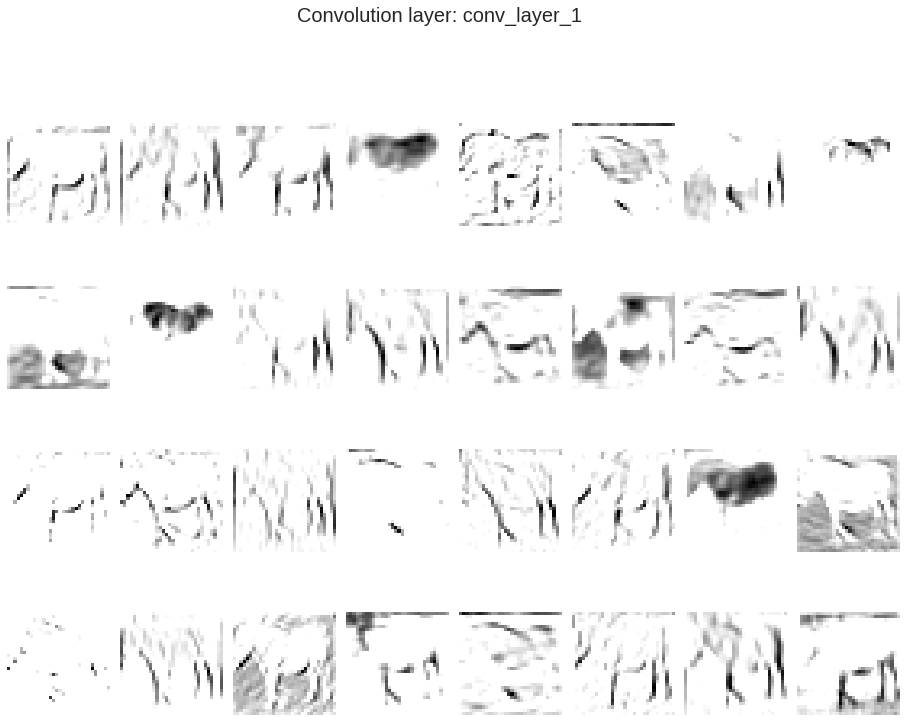

(16, 16, 128)


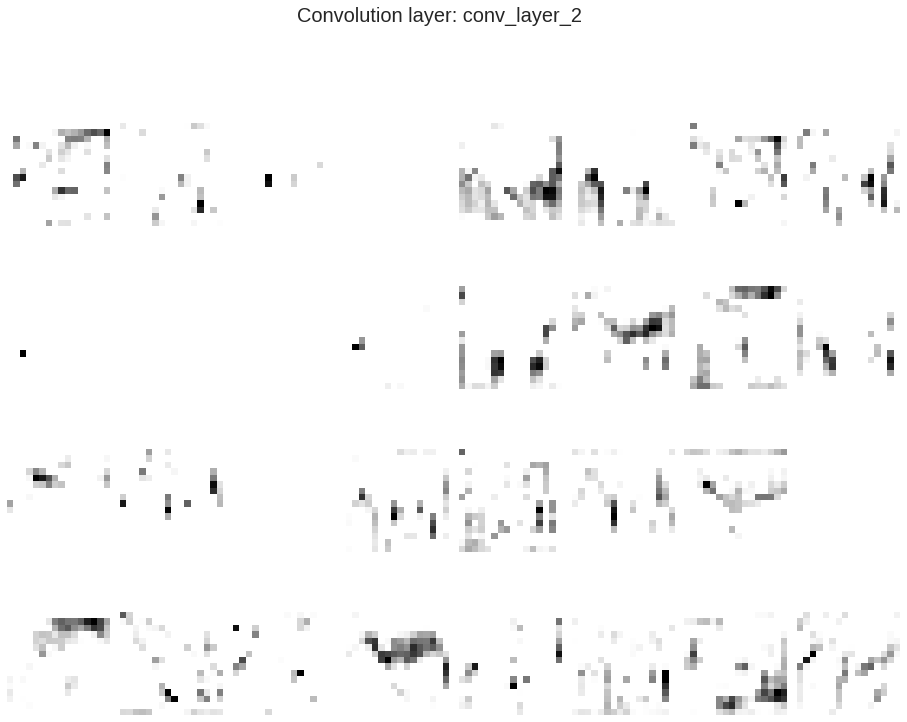

(8, 8, 512)


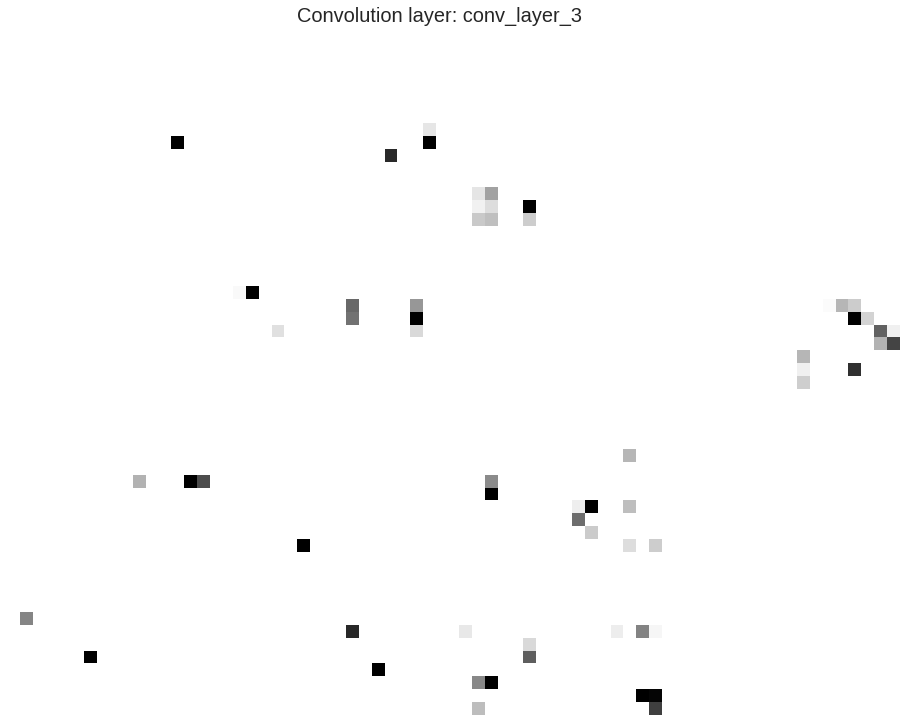

True

In [24]:
input_image = cifar10.train.images[7:8, :]
cnn.plot_layers(input_image, 'conv_layer_1')
cnn.plot_layers(input_image, 'conv_layer_2')
cnn.plot_layers(input_image, 'conv_layer_3')

(32, 32, 32)


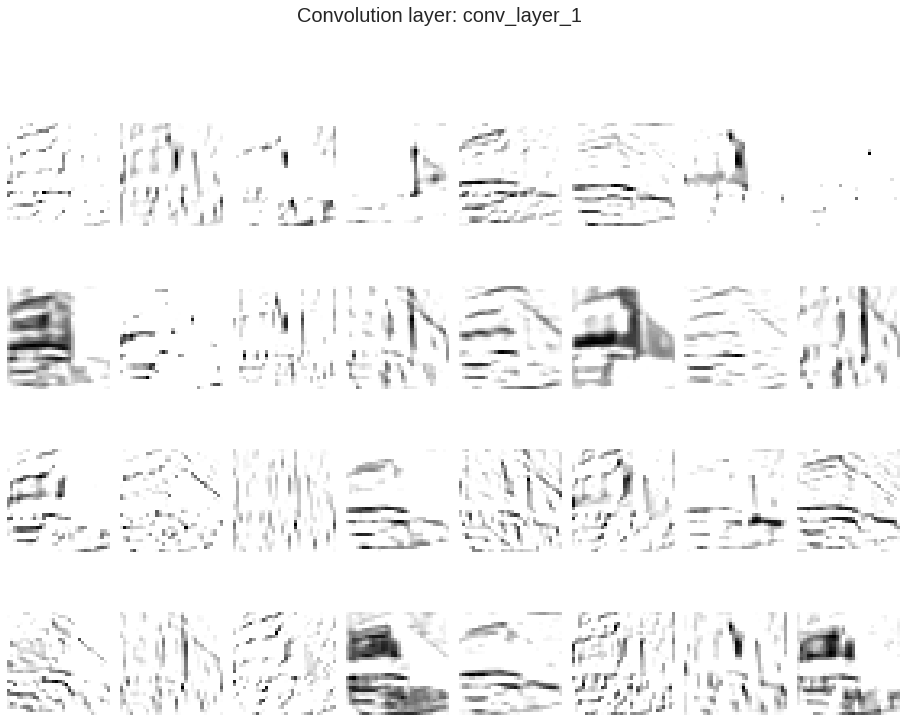

(16, 16, 128)


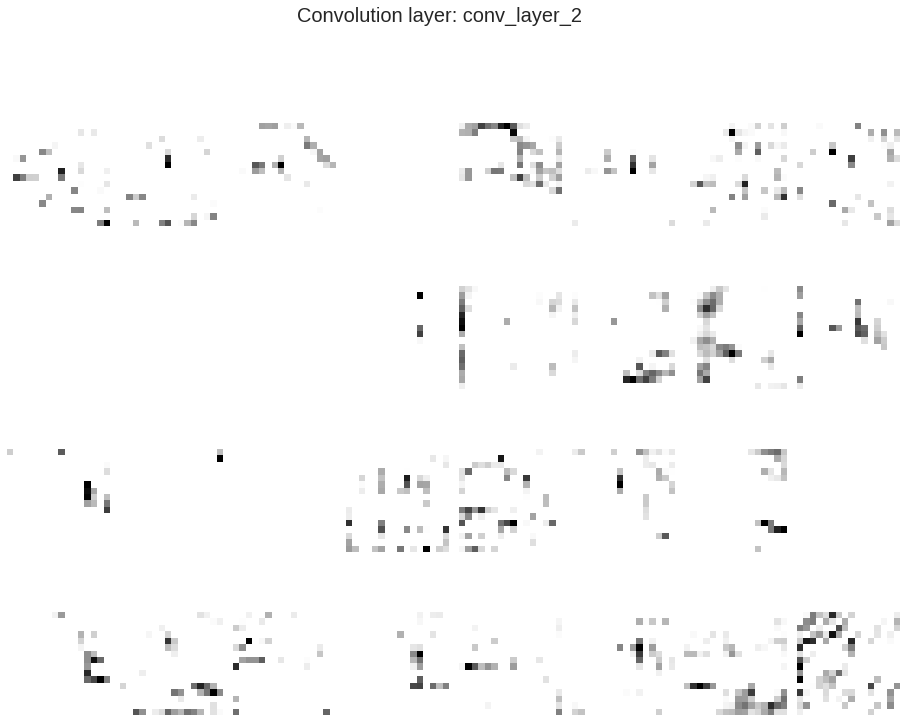

(8, 8, 512)


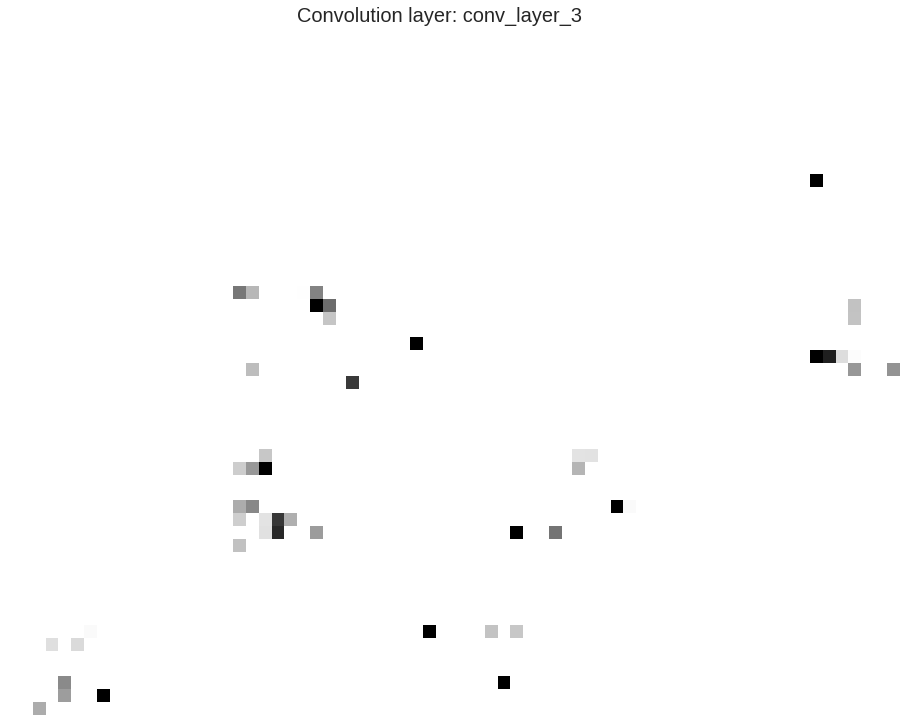

True

In [25]:
input_image = cifar10.train.images[1:2, :]
cnn.plot_layers(input_image, 'conv_layer_1')
cnn.plot_layers(input_image, 'conv_layer_2')
cnn.plot_layers(input_image, 'conv_layer_3')

### Step 2.4: Make the predictions

In [26]:
prediction_numbers = cnn.predict(cifar10.test.images)
prediction_classes = []
num_test_images = cifar10.test.images.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])

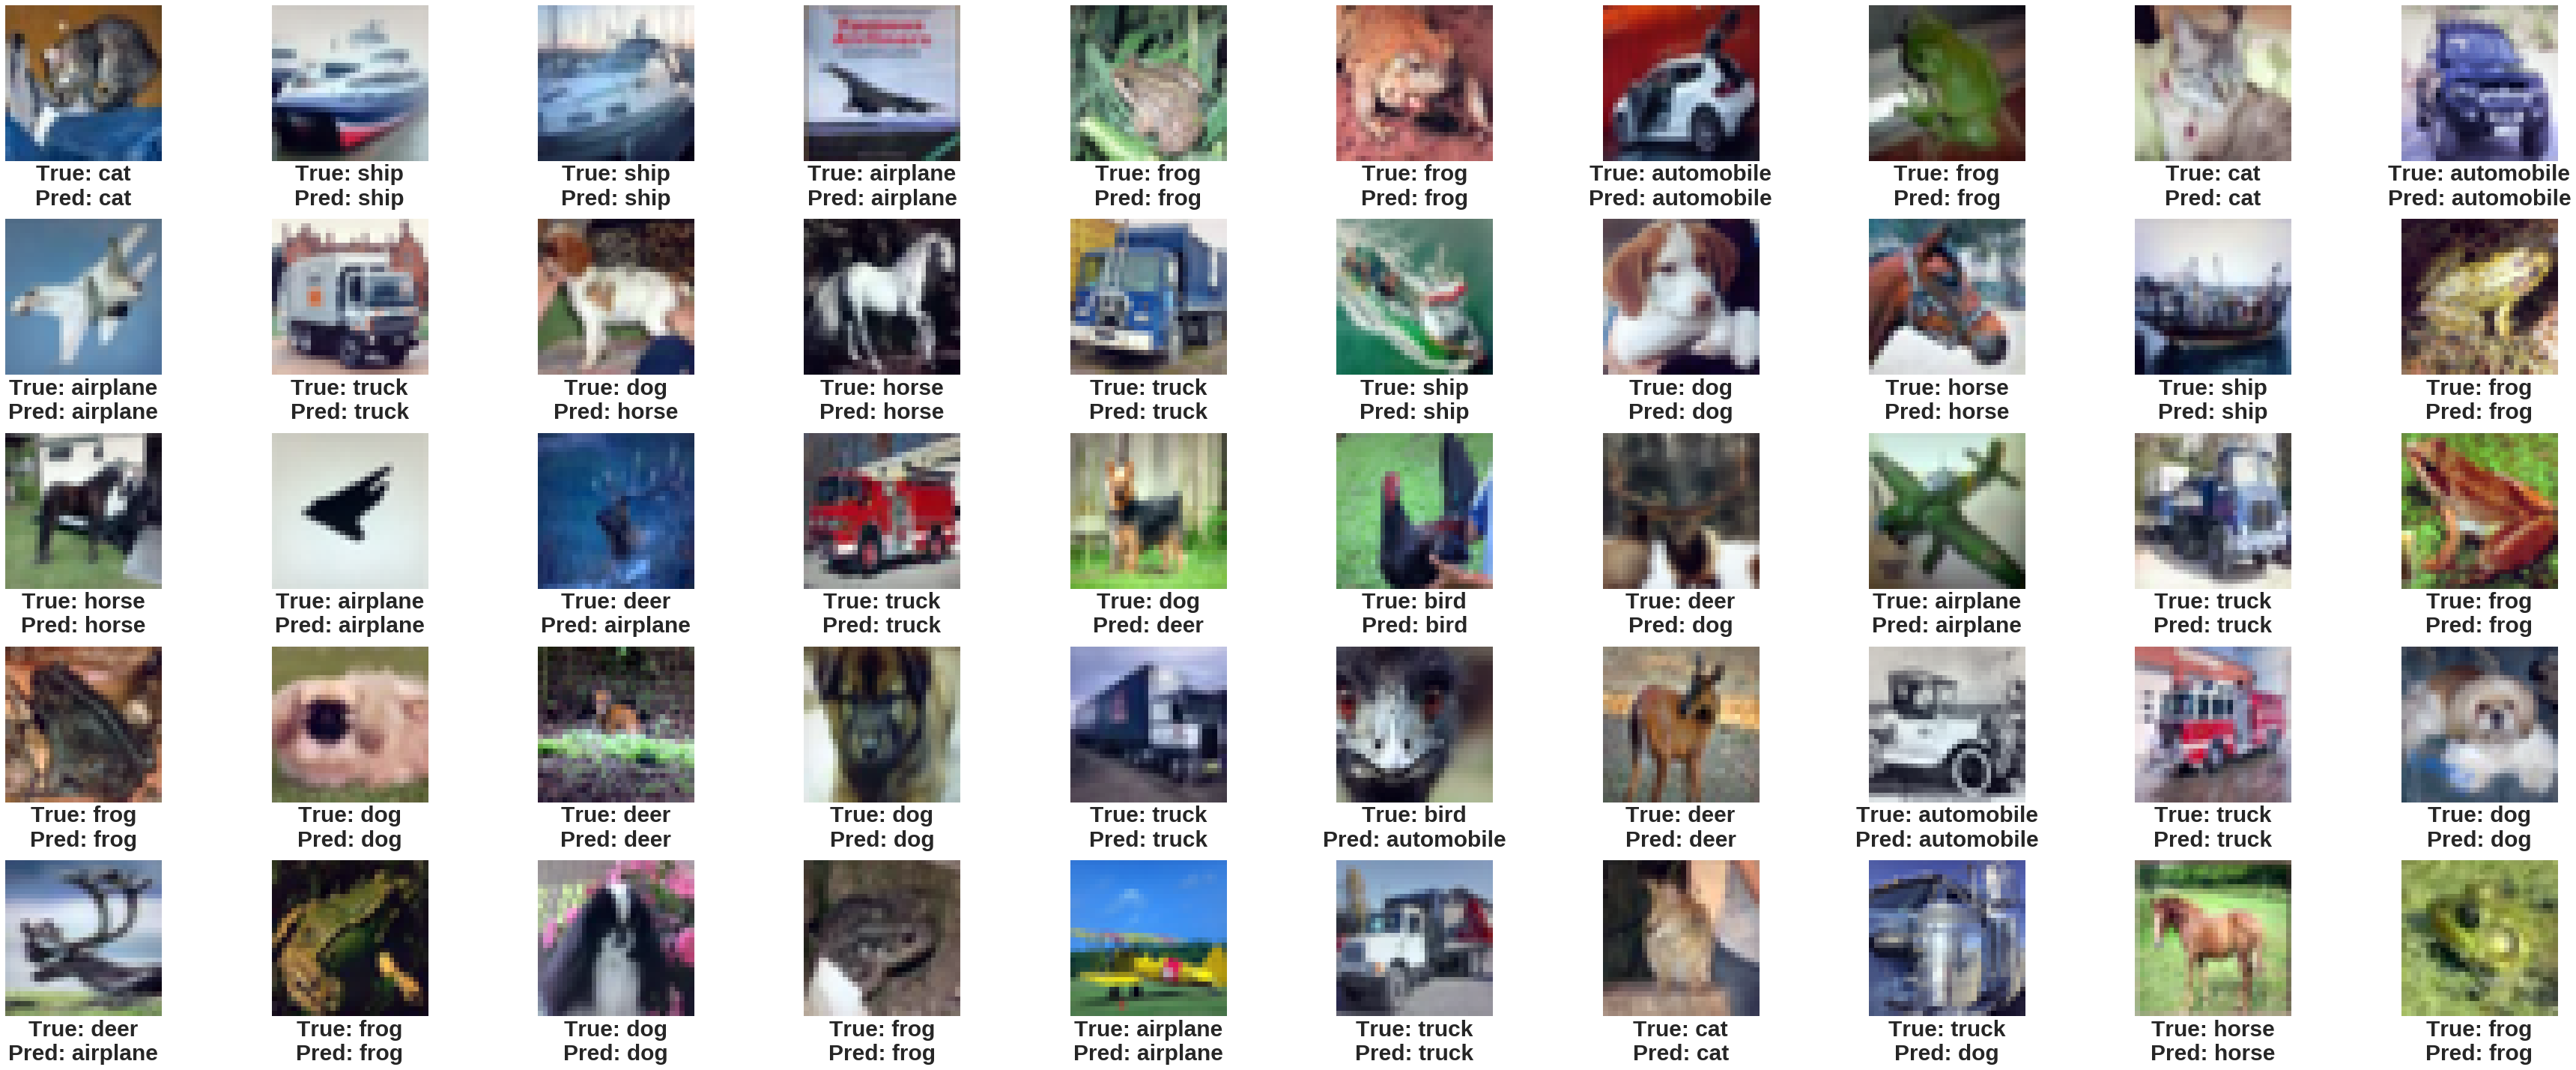

True

In [27]:
cifar10.plot_images(cifar10.test.images[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=30, convert=False)

### Step 2.5: Print the results

In [28]:
test_accuracy = cnn.score(cifar10.test.images, cifar10.test.class_labels)
print('Accuracy of the linear classifier on test dataset: %.4f' %test_accuracy)

Accuracy of the linear classifier on test dataset: 0.7948


Confusion matrix, without normalization
[[839  11  22  19  10   6   6  13  54  20]
 [ 11 916   0   5   2   5   4   3  17  37]
 [ 61   5 665  48  61  56  61  33   5   5]
 [ 19  10  46 604  41 154  61  41  14  10]
 [ 16   2  54  42 724  37  54  62   9   0]
 [  7   8  30 121  31 736  21  40   2   4]
 [  4   8  25  42  16  15 879   4   4   3]
 [  7   3  17  27  29  28  10 875   1   3]
 [ 41  20  11   4   4   4   6   7 888  15]
 [ 27  78   9   9   4   5  12  13  21 822]]
Normalized confusion matrix
[[ 0.839  0.011  0.022  0.019  0.01   0.006  0.006  0.013  0.054  0.02 ]
 [ 0.011  0.916  0.     0.005  0.002  0.005  0.004  0.003  0.017  0.037]
 [ 0.061  0.005  0.665  0.048  0.061  0.056  0.061  0.033  0.005  0.005]
 [ 0.019  0.01   0.046  0.604  0.041  0.154  0.061  0.041  0.014  0.01 ]
 [ 0.016  0.002  0.054  0.042  0.724  0.037  0.054  0.062  0.009  0.   ]
 [ 0.007  0.008  0.03   0.121  0.031  0.736  0.021  0.04   0.002  0.004]
 [ 0.004  0.008  0.025  0.042  0.016  0.015  0.879  0.004  0.00

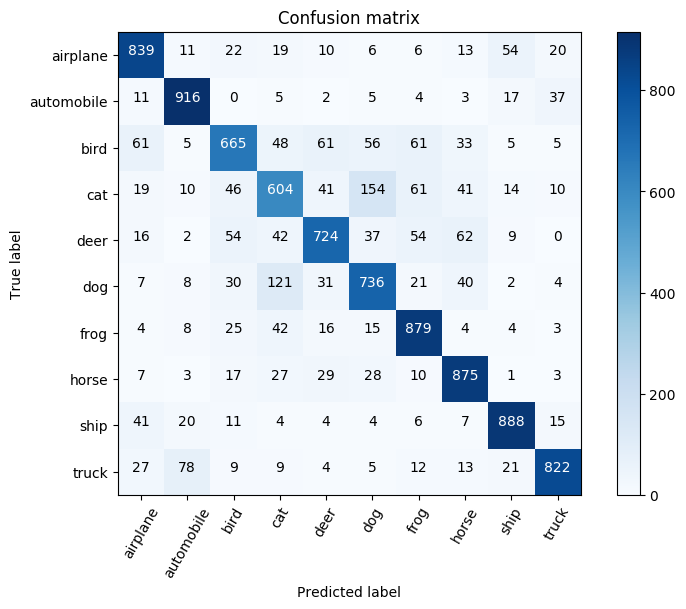

Detailed classification report
             precision    recall  f1-score   support

   airplane       0.81      0.84      0.83      1000
 automobile       0.86      0.92      0.89      1000
       bird       0.76      0.67      0.71      1000
        cat       0.66      0.60      0.63      1000
       deer       0.79      0.72      0.75      1000
        dog       0.70      0.74      0.72      1000
       frog       0.79      0.88      0.83      1000
      horse       0.80      0.88      0.84      1000
       ship       0.87      0.89      0.88      1000
      truck       0.89      0.82      0.86      1000

avg / total       0.79      0.79      0.79     10000



In [29]:
cnn.print_classification_results(cifar10.test.images, cifar10.test.one_hot_labels, cifar10.test.class_labels,
                                 test_class_names=cifar10.classes, normalize=True)

### Step 2.6: Plot results

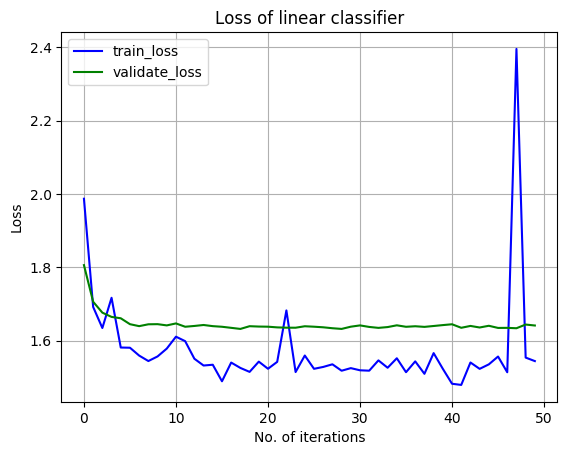

True

In [30]:
cnn.plot_loss()

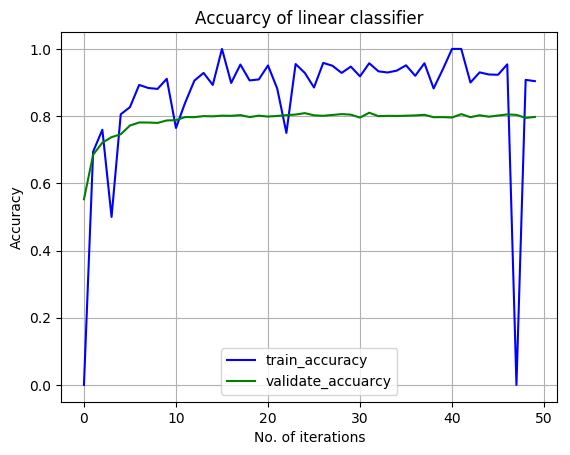

True

In [31]:
cnn.plot_accuracy()

## Step 3: Write to file

In [32]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [33]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [36]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [37]:
current_file = './' + theNotebook + '.ipynb'
output_file = log_dir + str(file_no).zfill(3) + '_exp_no_' + str(exp_no).zfill(3) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(log_dir) 
output_HTML(current_file, output_file)

Current file: ./105_Tf_CNN_Classifier_Raw_features_CIFAR_10.ipynb
Output file: ../logs/cifar10/105_tf_cnn_raw/exp_no_002/105_exp_no_002_105_Tf_CNN_Classifier_Raw_features_CIFAR_10.html



### Step 2.7: Close the session

In [38]:
cnn.close()